Loading Jacobians...27.9s
Loading obs_catalog...1.1s
[1] 2566 obs selected out of 125449 available (2.0%), 01-Sep-2014 to 01-Dec-2014
[2] 890 obs selected out of 45834 available (1.9%), 01-Dec-2014 to 01-Jan-2015
[3] 799 obs selected out of 37946 available (2.1%), 01-Jan-2015 to 01-Feb-2015
[4] 953 obs selected out of 46859 available (2.0%), 01-Feb-2015 to 01-Mar-2015
[5] 1052 obs selected out of 51757 available (2.0%), 01-Mar-2015 to 01-Apr-2015
[6] 943 obs selected out of 47153 available (2.0%), 01-Apr-2015 to 01-May-2015
[7] 794 obs selected out of 43609 available (1.8%), 01-May-2015 to 01-Jun-2015
[8] 988 obs selected out of 49338 available (2.0%), 01-Jun-2015 to 01-Jul-2015
[9] 1019 obs selected out of 52764 available (1.9%), 01-Jul-2015 to 01-Aug-2015
[10] 1082 obs selected out of 54084 available (2.0%), 01-Aug-2015 to 01-Sep-2015
[11] 957 obs selected out of 48592 available (2.0%), 01-Sep-2015 to 01-Oct-2015
[12] 822 obs selected out of 42111 available (2.0%), 01-Oct-2015 to 01-

Loading required package: plotrix



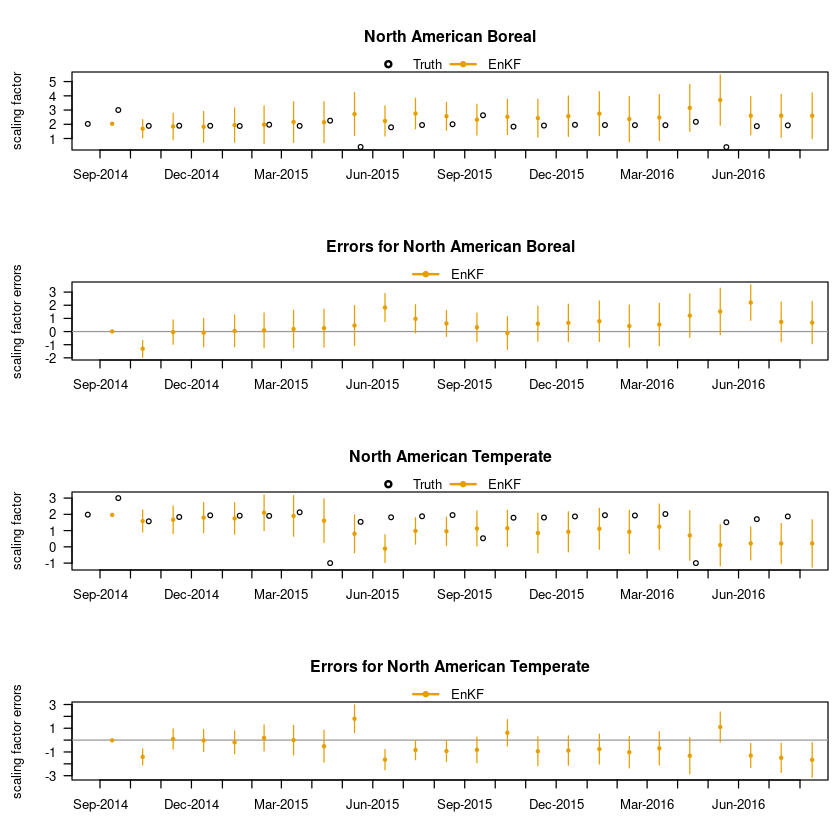

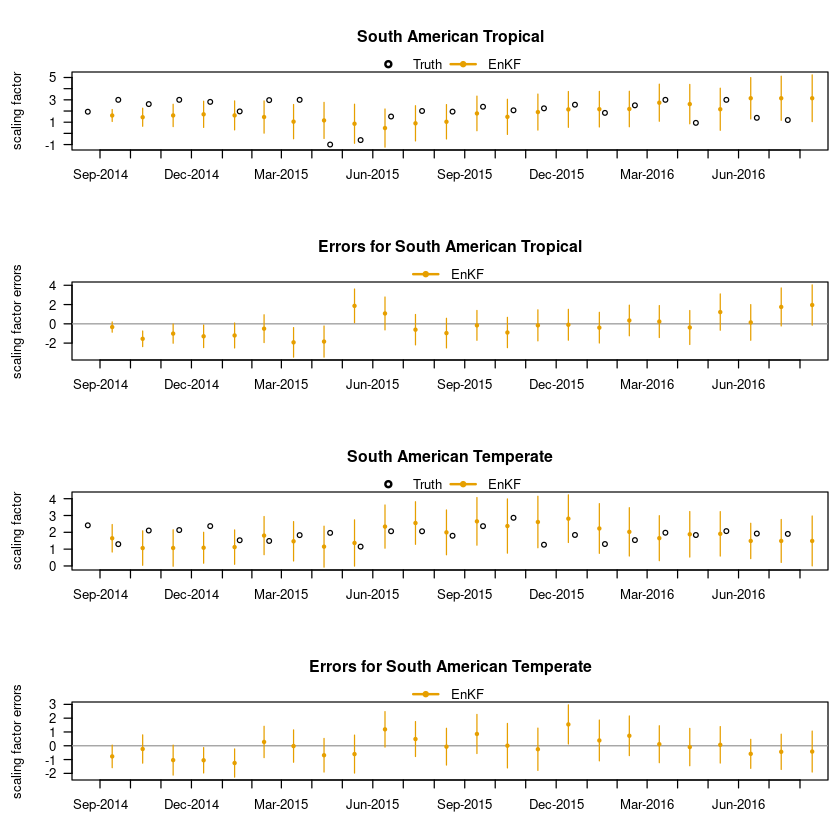

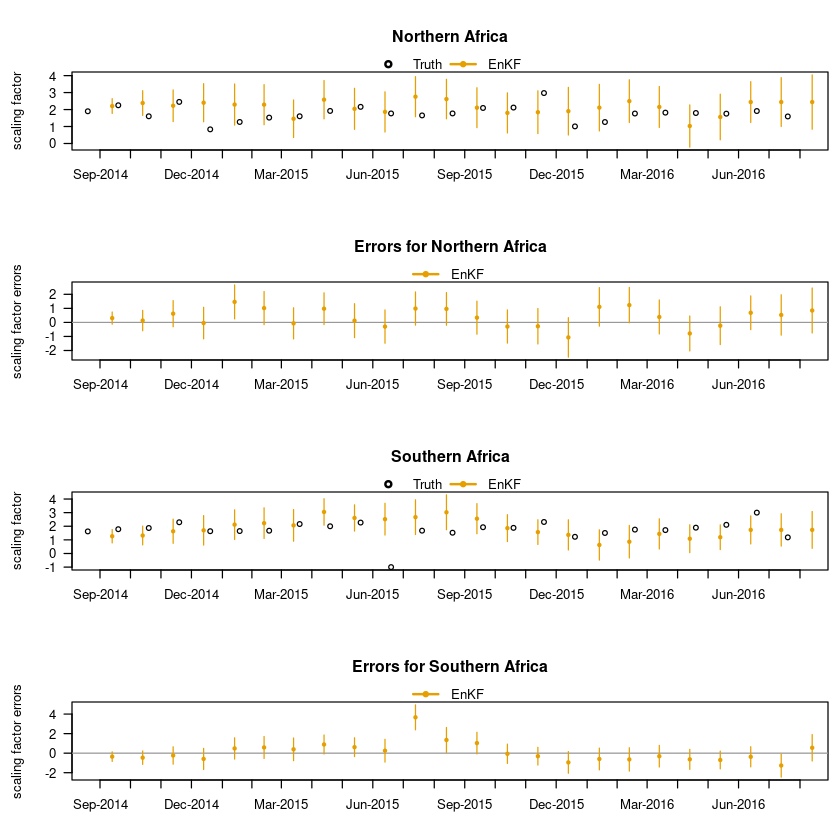

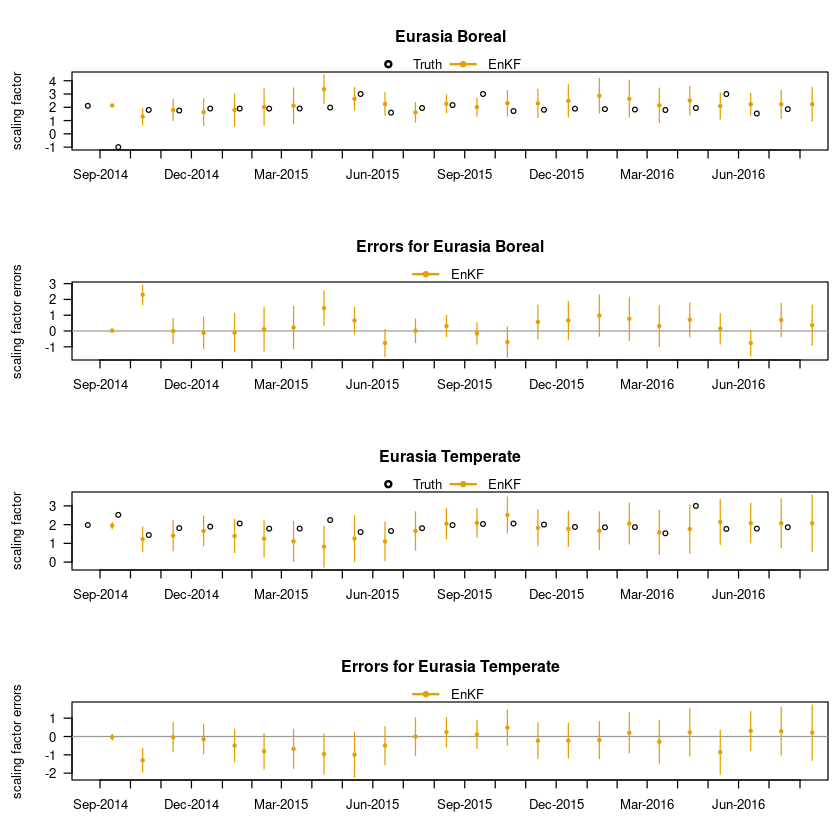

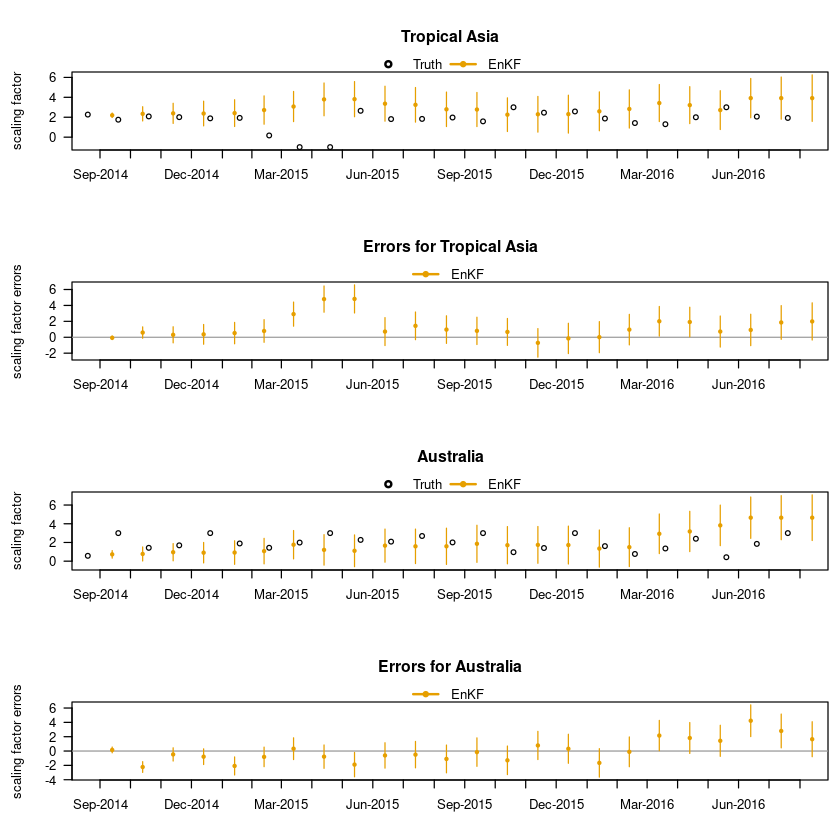

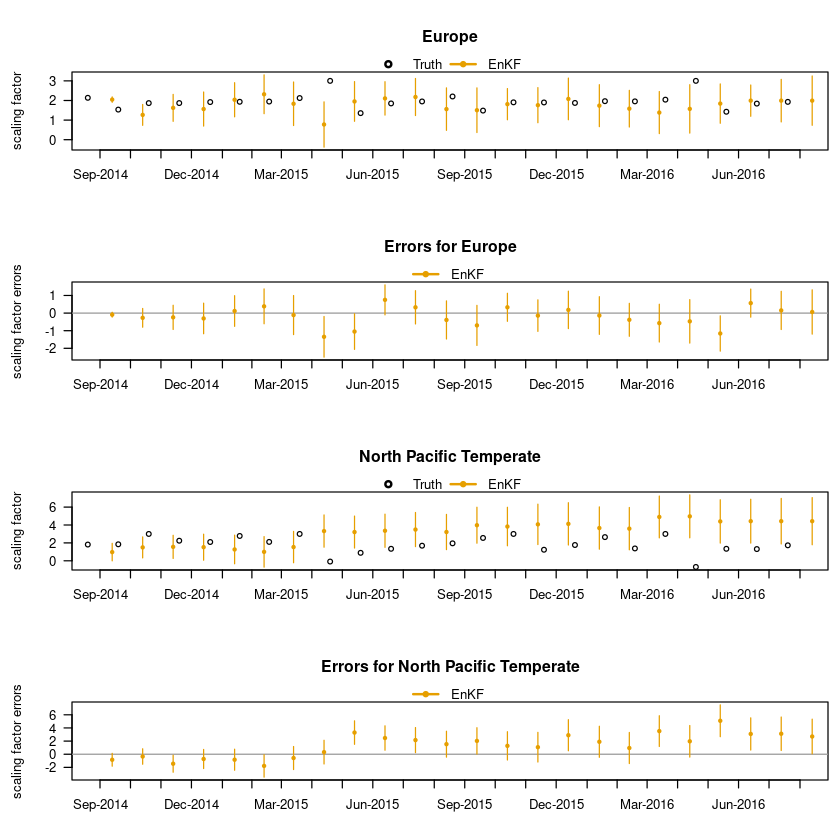

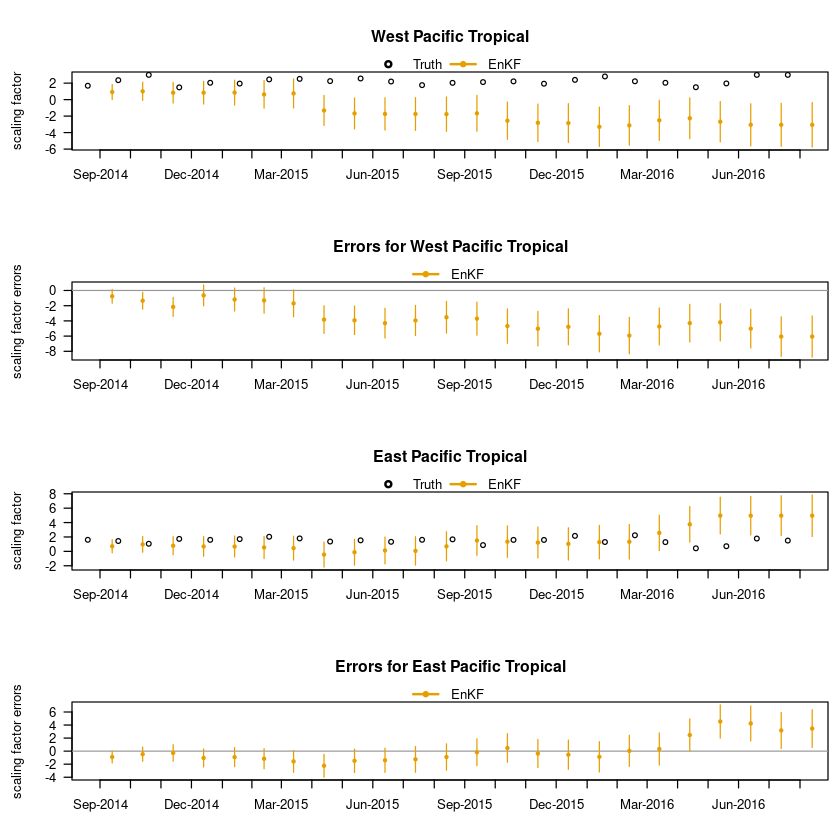

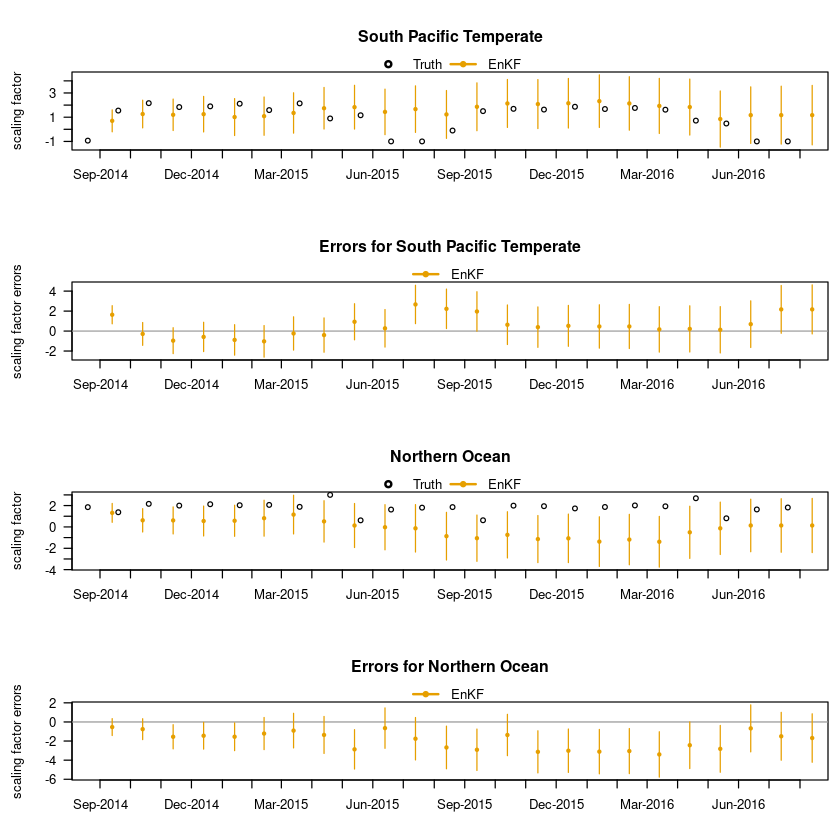

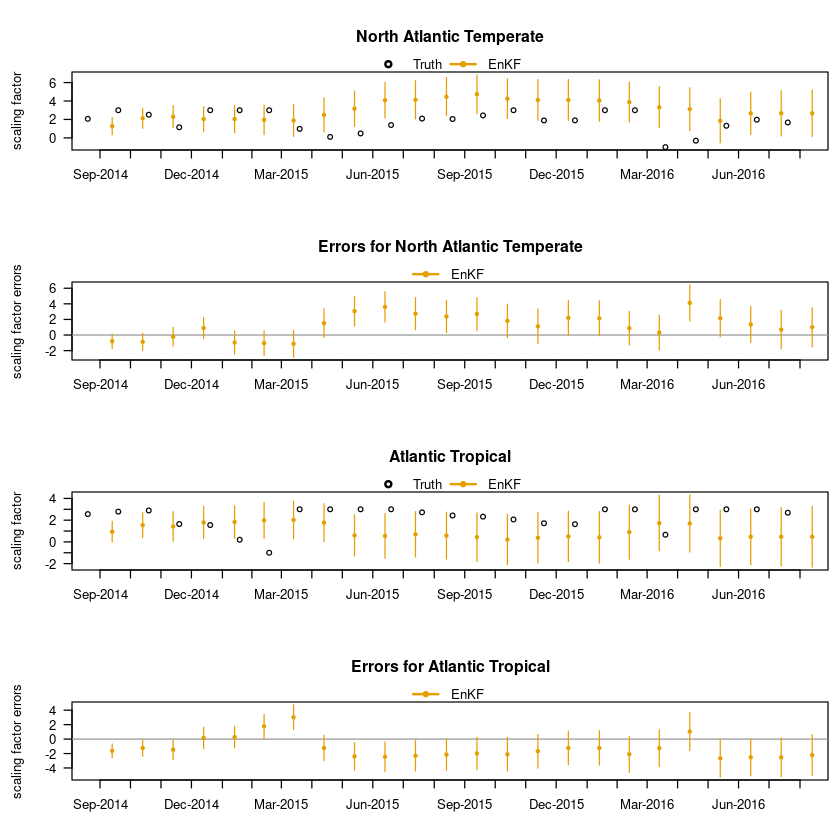

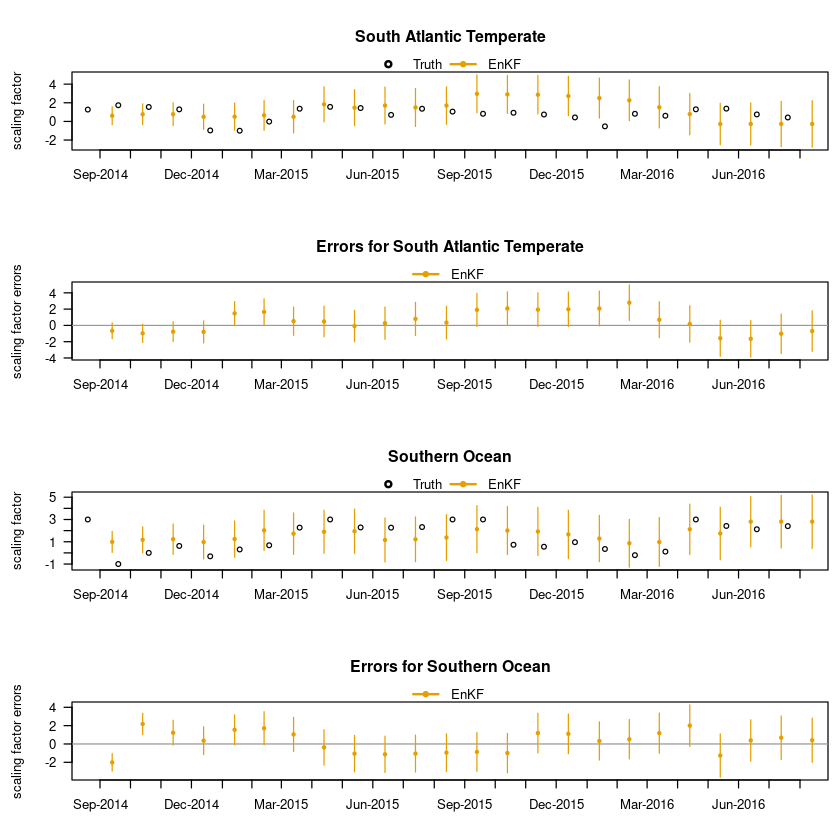

Loading priors integrated over Transcom regions...0.1s


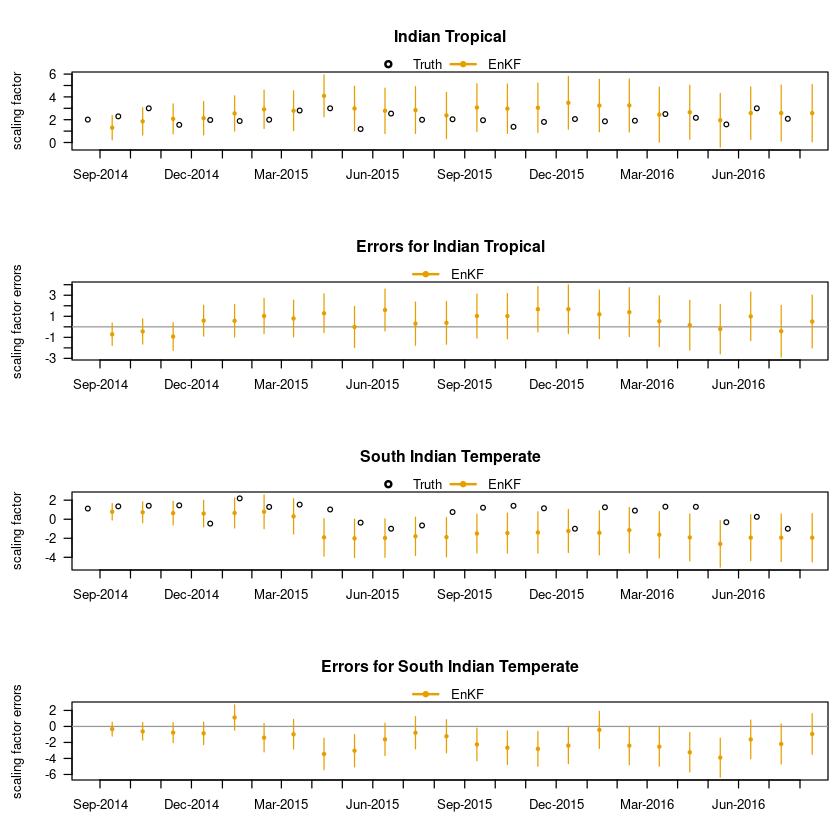

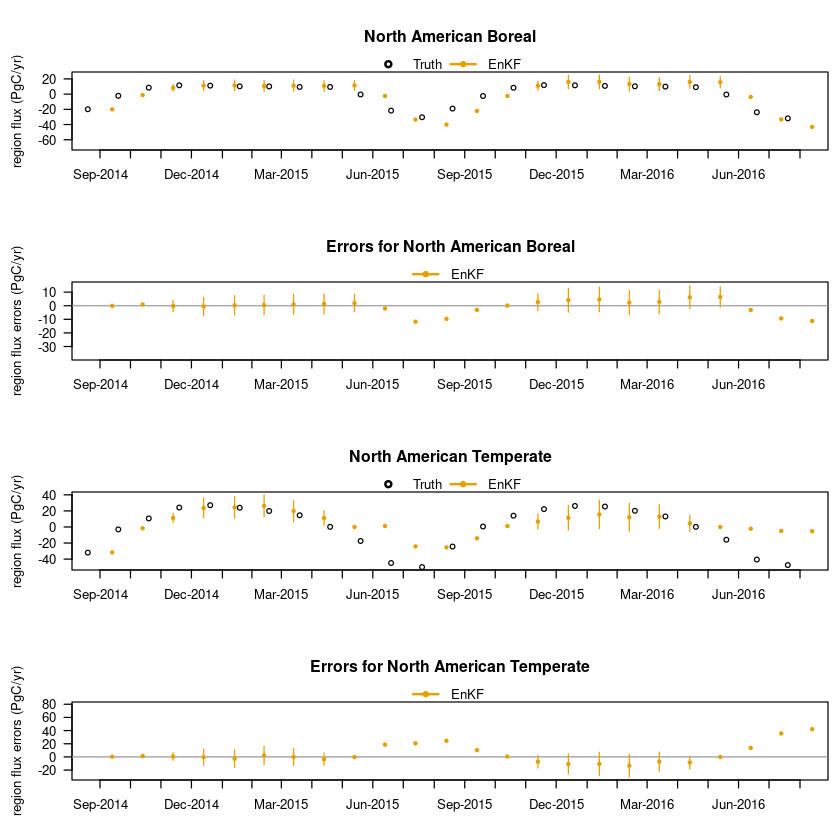

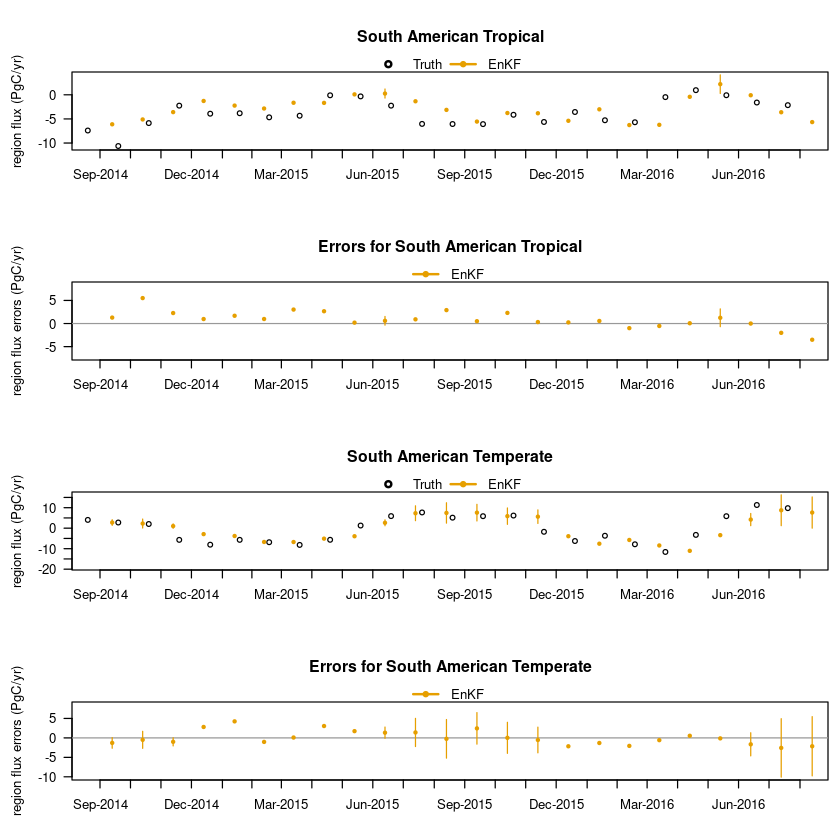

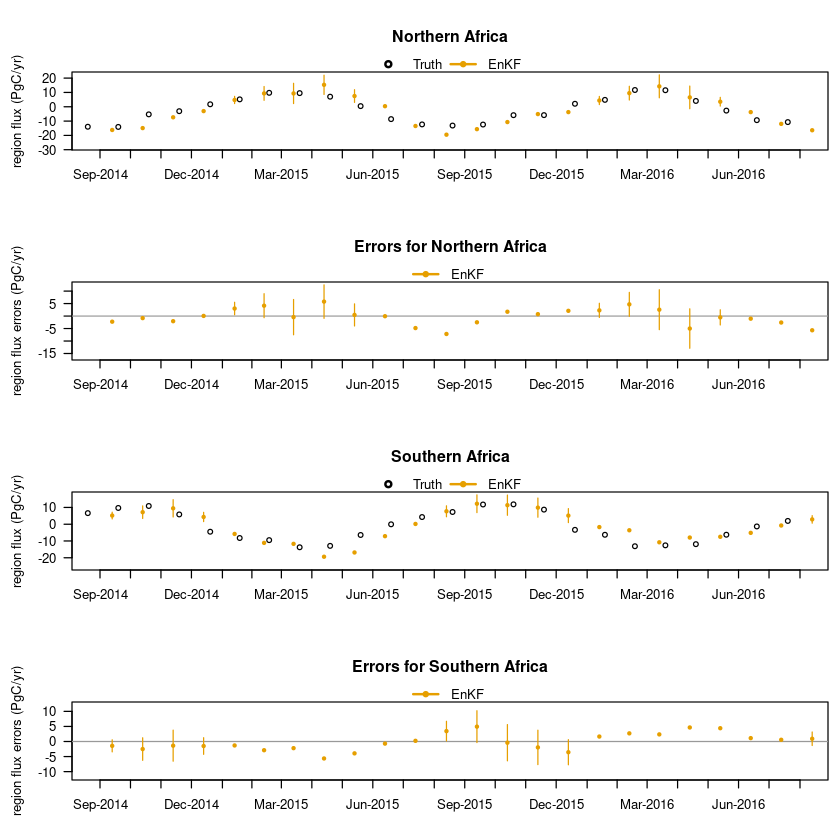

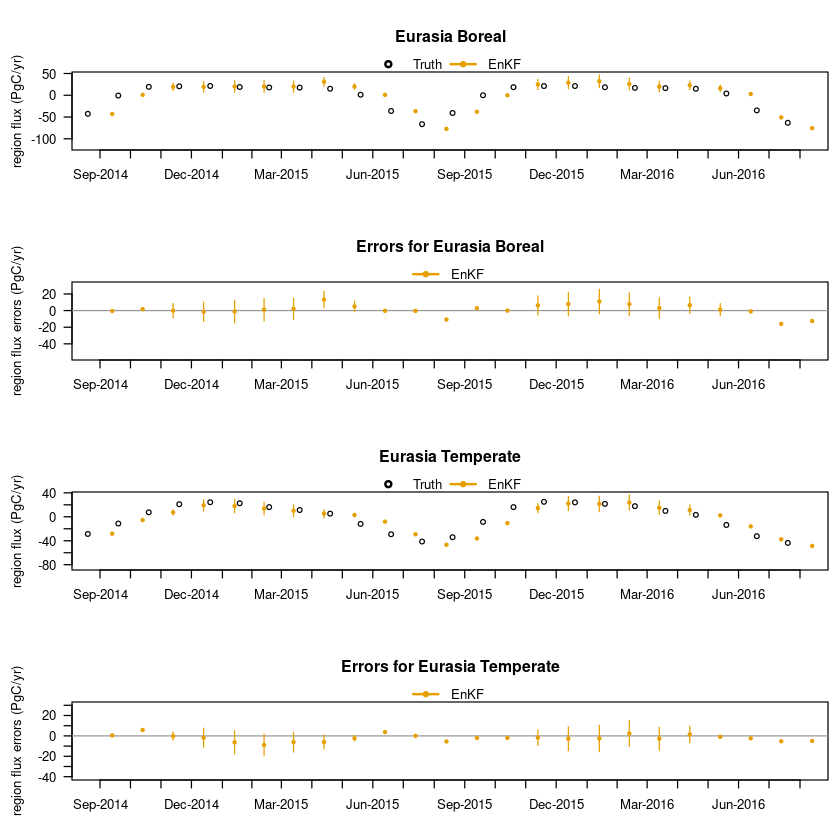

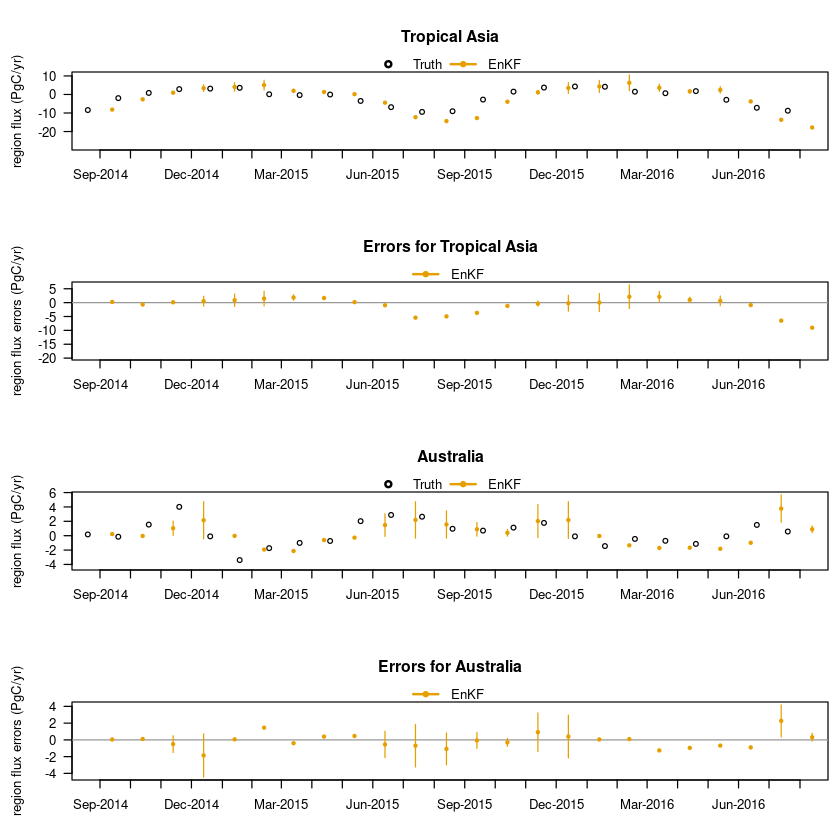

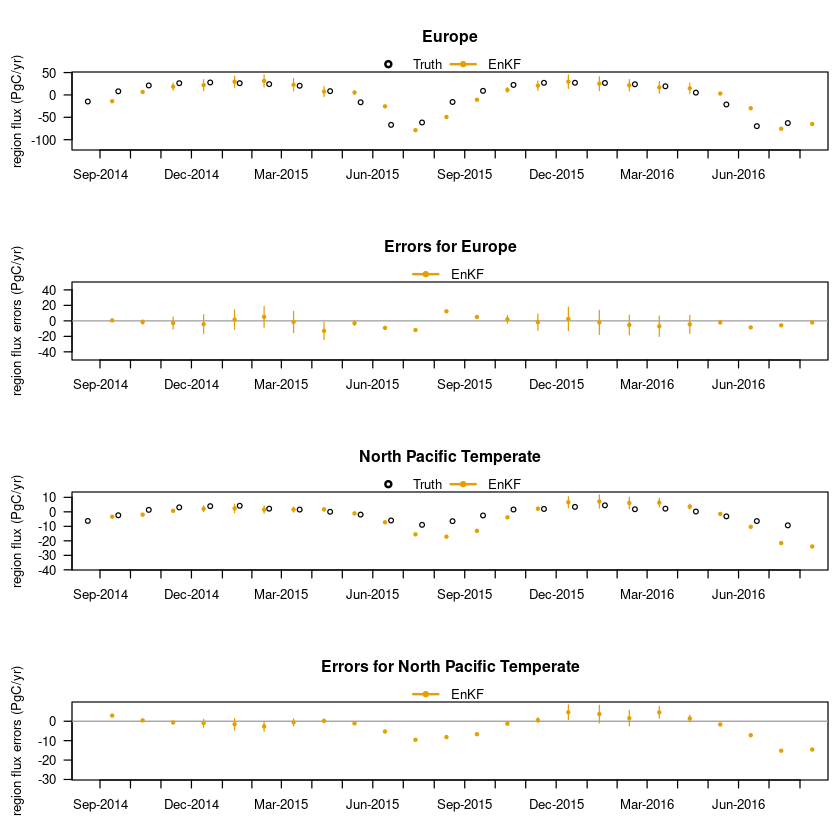

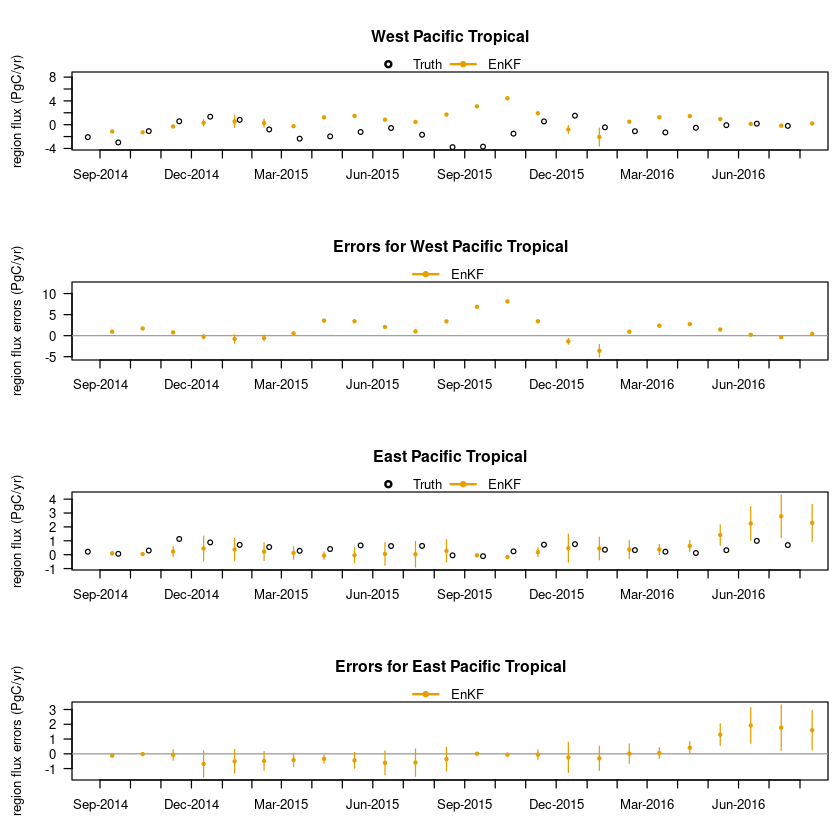

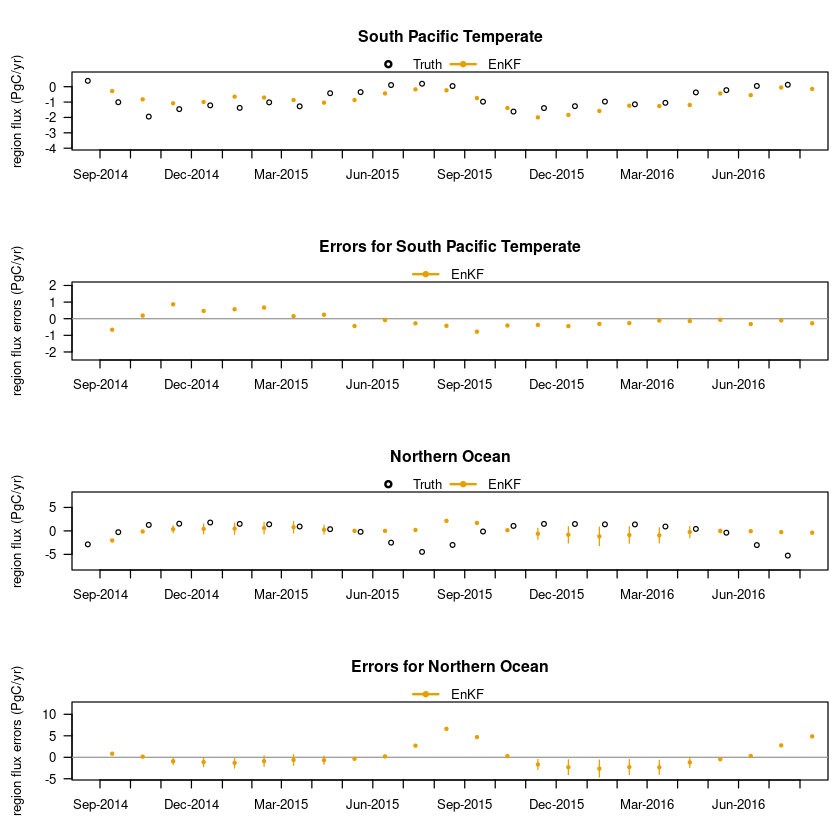

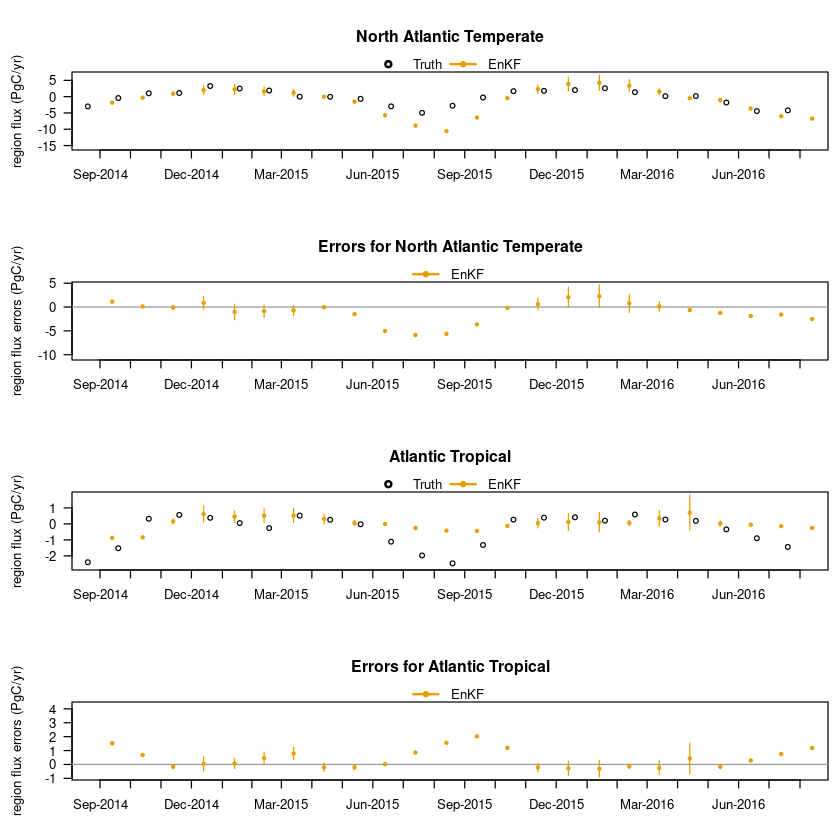

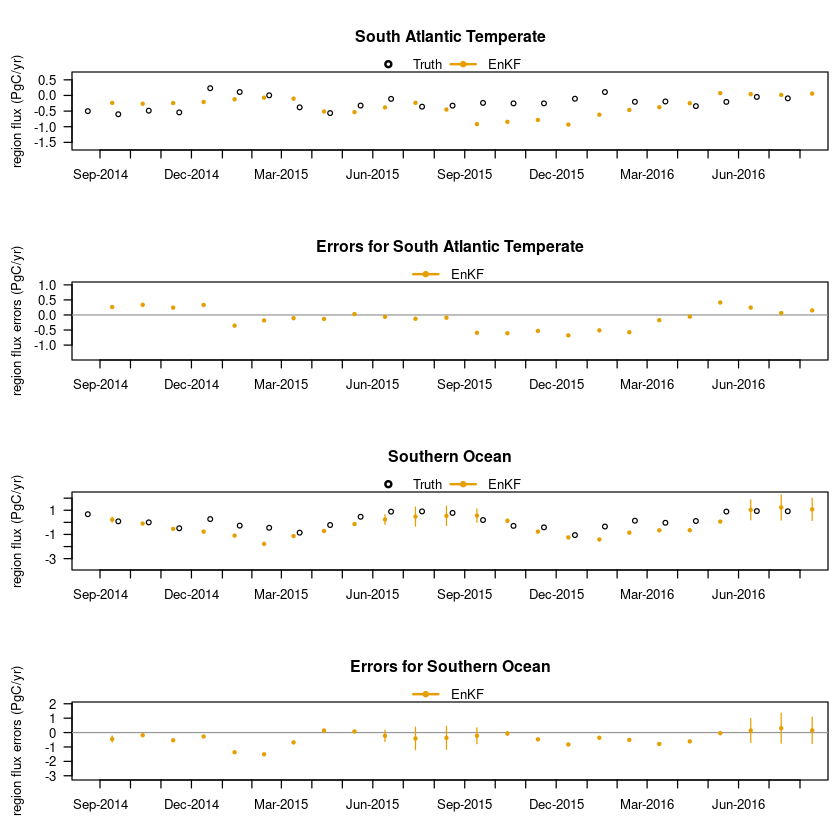

Loading obs_catalog...1.1s
co2_mlo_surface-insitu_1_allvalid: 3577 obs, from 2014-09-03 09:30:00 to 2016-08-30 12:00:00
co2_brw_surface-insitu_1_allvalid: 3550 obs, from 2014-09-01 19:30:00 to 2016-08-31 12:00:00
co2_smo_surface-insitu_1_allvalid: 2762 obs, from 2014-09-01 00:30:00 to 2016-08-31 12:00:00


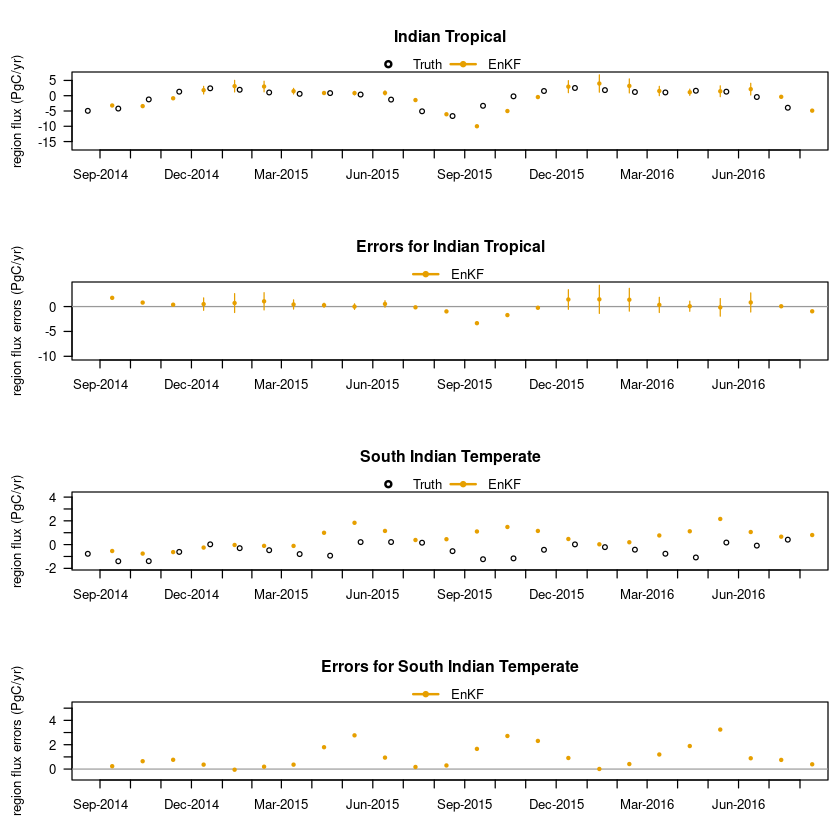

co2_spo_surface-insitu_1_allvalid: 5181 obs, from 2014-09-01 00:30:00 to 2016-08-31 12:00:00
co2_lef_tower-insitu_1_allvalid-396magl: 15976 obs, from 2014-09-01 00:30:00 to 2016-08-31 12:00:00


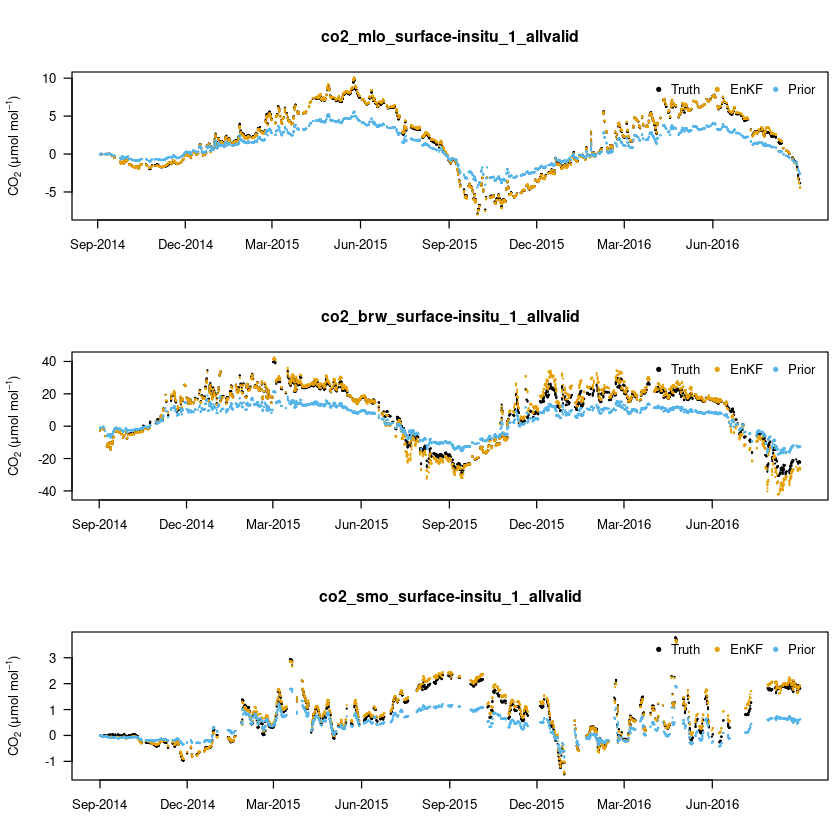

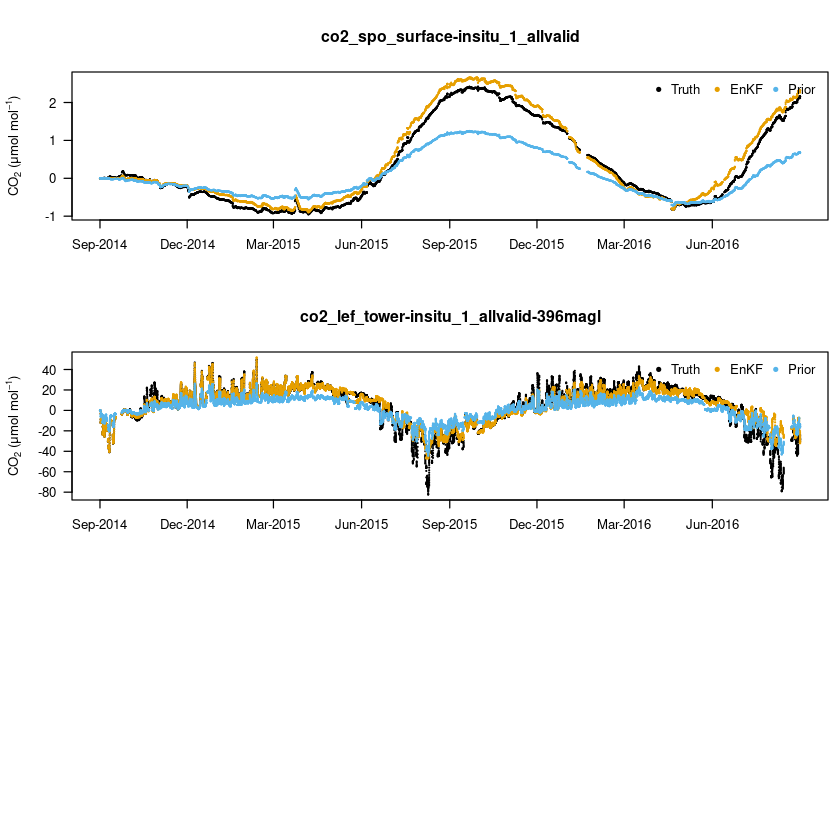

In [1]:
# Time-stamp: <hercules-login-4.hpc.msstate.edu:/work/noaa/co2/andy/Projects/enkf_summer_school/repo/ssim-ghg-2024/EnKF/time-varying/persist.r: 13 Jun 2024 (Thu) 19:36:56 UTC>

# This code applies the EnKF measurement update to a truth condition
# generated from scaling factors derived from OCO-2 v10 MIP models.

# Add local library for R packages
.libPaths(new=c(sprintf("%s/shared/lib/R-4.3/x86_64-pc-linux-gnu",Sys.getenv("HOME")),.libPaths())) 

source("../tools/enkf.r")
source("../tools/progress.bar.r")
source("../tools/find.indir.r")
source("../tools/time.r")
source("../tools/load.ncdf4.r")
options(warn=2) # error out on warnings (probably they are mistakes)
indir <- find.indir()

# Since these load() statements can take some time, we can supply
# them pre-loaded from memory or load them here.
if(!exists("H.orig")) {
  t0 <- proc.time()[3]
  cat("Loading Jacobians...")
  load(file.path(indir,"inversion_examples/jacobians/trunc_full_jacob_030624_with_dimnames_sib4_4x5_mask.rda"))
  H <- jacob*(12/44) # Andrew reports units conversion needed
  rm(jacob)
  # We'll be subsetting H later; preserve the original matrix for
  # later use.
  H.orig <- H
  cat(sprintf('%.1fs\n',proc.time()[3]-t0))
}
  
if(!exists("obs_catalog")) {
  t0 <- proc.time()[3]
  cat("Loading obs_catalog...")
  load(file.path(indir,"inversion_examples/obs/obs_catalog_042424_unit_pulse_hour_timestamp_witherrors_withdates.rda"))
  # change time zone to "UTC" for obs_catalog times (is by default
  # "GMT")
  attributes(obs_catalog$DATE)$tzone <- "UTC"
  cat(sprintf('%.1fs\n',proc.time()[3]-t0))
}

nreg <- 22
nlag <- 3 # months
nparms <- nreg*nlag
nmons <- 24
nmemb <- 300
# probability (0-1) that obs will be randomly selected for
# assimilation
obs.prob <- 0.02

# This function maps a set of nreg parameters for a given month (22
# values) onto the nreg*nmons.prior (528) space
parm.indices <- function(imon) {
  return((0:21)*24 + imon)
}

load(file.path(indir,"inversion_examples/misc/truth_array.rda"))

# Andrew uses a tm() function to limit the range of values in an
# array. This function does the same but is very explicit. Note that
# the which() function temporarily casts x from a multidimensional
# array to a vector, and the x[lx] assignment does the same. The
# dimensions attribute of x is unaffacted, so the array size is
# unaffected. 
trim <- function(x,limits) {
  if(length(limits)!=2) {
    stop("Expecting 2-vector for limits argument")
  }
  lx <- which(x < limits[1])
  if(length(lx)>0) {
    x[lx] <- limits[1]
  }
  lx <- which(x > limits[2])
  if(length(lx)>0) {
    x[lx] <- limits[2]
  }
  return(x)
}

truth_condition <- -1 * trim(truth_array[1:24,2:23,1,1],c(-2,2))
dim(truth_condition) <- c(nreg*nmons,1) 
# Finally, add back the 1.0 that Andrew removed
truth_condition <- truth_condition + 1.0

# generate obs
nobs <- dim(H)[1]
# "d" suffix means its the diagonal (of a diagonal matrix)
Szd.actual <- rep(0.5^2,nobs) # variance in ppm^2
#Szd.assumed <- rep((0.1)^2,nobs) # variance in ppm^2
Szd.assumed <- Szd.actual
# Note that supplying a Szd argument to the simulate_observed function
# will result in perturbations being added to the observations.  This
# would be the place to add biases to obs.
obs <- simulate_observed(H=H,
                         x=matrix(truth_condition,nrow=nreg*nmons),
                         Szd=Szd.actual)
dim(obs) <- c(nobs,1)


state.enkf <- list()
state.enkf$x.prior <- matrix(NA,nrow=nparms,ncol=nmons+nlag)
state.enkf$dx.prior <- array(NA,dim=c(nmemb,nparms,nmons+nlag))
state.enkf$x.post <- matrix(NA,nrow=nparms,ncol=nmons+nlag)
state.enkf$dx.post <- array(NA,dim=c(nmemb,nparms,nmons+nlag))

state.kf <- list()
state.kf$x.prior <- matrix(NA,nrow=nparms,ncol=nmons+nlag)
state.kf$Sx.prior <- array(NA,dim=c(nparms,nparms,nmons+nlag))
state.kf$x.post <- matrix(NA,nrow=nparms,ncol=nmons+nlag)
state.kf$Sx.post <- array(NA,dim=c(nparms,nparms,nmons+nlag))

Sx.prior <- diag(1,nparms)
state.kf$x.prior[,1] <- 1
state.enkf$x.prior[,1] <- 1
state.kf$Sx.prior[,,1] <- Sx.prior
state.enkf$dx.prior[,,1] <- generate_ensemble(Sx=Sx.prior,nmemb=nmemb) # prior deviations

time.edges <- seq(ISOdatetime(2014,9,1,0,0,0,tz="UTC"),
                  ISOdatetime(2016,12,1,0,0,0,tz="UTC"),
                  by="1 month")

# While prior is 1, zeros here makes sense because we're using it to
# generate obs, and we cannot have influence of fluxes after the time
# of a given measurement.
enkf.x.working <- matrix(1,nrow=(nmons+3)*nreg,ncol=1)

# Create empty vector to be used for storage later. We use this vector
# to keep track of which obs are actually chosen for assimilation.
lx.selected.all <- numeric(0)

for (imon in 1:nmons) {

  # On first time step, assimilate all obs from beginning to nlag
  # months, on subsequent time steps, just one months' worth of obs
  if(imon==1) {
    t0 <- min(obs_catalog$DATE) # (or time.edges[1], no difference)
  } else {
    t0 <- time.edges[imon+nlag-1]
  }
  t1 <- time.edges[imon+nlag]
  if(any(is.na(c(t0,t1)))) { 
    n.window <- 0
    n.selected <- 0
  } else {
    lx.window <- which((obs_catalog$DATE >= t0) &
                       (obs_catalog$DATE < t1))
    n.window <- length(lx.window)
    
    lx.selected <- lx.window[which(runif(n=n.window)<=obs.prob)]
    lx.selected.all <- c(lx.selected.all,lx.selected)
    n.selected <- length(lx.selected)

    if(n.window >0) {
      pctage <- 100*n.selected/n.window
    } else {
      pctage <- 0
    }
    cat(sprintf("[%d] %d obs selected out of %d available (%.1f%%), %s to %s\n",
                imon,n.selected,n.window,pctage,
                format(t0,"%d-%b-%Y"),
                format(t1,"%d-%b-%Y")))
  }

  # Populate imon through imon + nlag -1 monthly slots of the working
  # array with priors. For months that have fallen out of the
  # assimilation window, this working array will have posteriors. All
  # of these will be used to generate simulated values for
  # measurements.
  for (ilag in 1:nlag) {
    enkf.x.working[parm.indices(imon+ilag-1),1] <- state.enkf$x.prior[seq(ilag,by=3,length.out=22),imon]
  }

  if(n.selected > 0) {

    # assimilate
    these.obs <- obs[lx.selected]
    these.Szd <- Szd.assumed[lx.selected]

    # We need a state vector and an ensemble with the total number of
    # parameters, 22x24, to multiply the Jacobian H. The working state
    # vector will have posteriors for months that have fallen out of
    # the assimilation window, priors within the window, and zeros for
    # months not yet in the window. The deviations ensemble will have
    # zeros for all months outside of the window.

    y.prior <- simulate_observed(H=H[lx.selected,],
                                 x=enkf.x.working[1:(nreg*nmons)])

    dx.working <- matrix(0,nrow=nmemb,ncol=nmons*nreg)
    for (ilag in 1:nlag) {
      dx.working[,parm.indices(imon+ilag-1)] <- state.enkf$dx.prior[,seq(ilag,by=3,length.out=22),imon]
      
    }

    dy.prior <- t(simulate_observed(H=H[lx.selected,],
                                    x=t(dx.working)))


    # R stores matrices in column-major format. That means if a matrix
    # "foo" is 2x3 (nrow x ncolumn) and looks like:
    #   > foo
    #          [,1]   [,2]   [,3]
    #   [1,] "r1c1" "r1c2" "r1c3"
    #   [2,] "r2c1" "r2c2" "r2c3"
    #   > dim(foo)
    #   [1] 2 3
    
    # Then if we assign dims 6x1 to it, we will get:
    #   > dim(foo) <- c(6,1)
    #   > foo
    #          [,1]
    #   [1,] "r1c1"
    #   [2,] "r2c1"
    #   [3,] "r1c2"
    #   [4,] "r2c2"
    #   [5,] "r1c3"
    #   [6,] "r2c3"
    #
    # The r1c1, r2c1, r1c2, ... ordering is how column-major data are
    # stored in memory: the rows change quickest, the columns slowest.
    
    # The original matrix can be retrieved by just assigning 2x3
    # dimensions back to foo.  We will change dimensions on matrices
    # knowing that this storage order is preserved:
    #
    #   > dim(foo) <- c(2,3)
    #   > foo
    #          [,1]   [,2]   [,3]
    #   [1,] "r1c1" "r1c2" "r1c3"
    #   [2,] "r2c1" "r2c2" "r2c3"

    post <- enkf_meas_update_loc(x=state.enkf$x.prior[,imon],
                                 dx=state.enkf$dx.prior[,,imon],
                                 obs=these.obs,
                                 Szd=these.Szd,
                                 y=y.prior,dy=dy.prior,
                                 localization_mask=NULL)

    state.enkf$x.post[,imon] <- post$x
    state.enkf$dx.post[,,imon] <- post$dx

    # Populate imon through imon + nlag -1 monthly slots of the
    # working array with posteriors.  Those months falling out of the
    # assimilation window will never again get updated. Those
    # remaining in the window will receive further updates.
    
    for (ilag in 1:nlag) {
      enkf.x.working[parm.indices(imon+ilag-1)] <- state.enkf$x.post[seq(ilag,by=3,length.out=22),imon]
    }

  } else {
    # No obs -> no change
    state.enkf$x.post[,imon] <- state.enkf$x.prior[,imon]
    state.enkf$dx.post[,,imon] <- state.enkf$dx.prior[,,imon]
  }

  # time propagation
  
  psi <- diag(1,nparms) # persistence
  Spsi <- diag(0.5,nparms) # process noise covariance matrix
  state.enkf$x.prior[,imon+1] <- psi %*% state.enkf$x.post[,imon]
  Spsi.deviations <- generate_ensemble(Sx=Spsi,nmemb=nmemb)
  for (imemb in 1:nmemb) {
    state.enkf$dx.prior[imemb,,imon+1] <- psi %*% state.enkf$dx.post[imemb,,imon] + Spsi.deviations[imemb,]
  } # imemb loop

} # imon loop

# Compute sample covariance matrices (528x528)
state.enkf$Sx <- matrix(0,nrow=nmons*nreg,ncol=nmons*nreg)
state.enkf$Sx.prior <- matrix(0,nrow=nmons*nreg,ncol=nmons*nreg)
for(imon in 1:nmons) {
  lx <- parm.indices(imon)
  state.enkf$Sx[lx,lx] <- cov(state.enkf$dx.post[,seq(1,by=3,length.out=22),imon])  
  state.enkf$Sx.prior[lx,lx] <- cov(state.enkf$dx.prior[,seq(1,by=3,length.out=22),imon])
}

posterior.dofs <- TRUE

if(posterior.dofs) {
  ndofs.enkf <- ndofs.patil(state.enkf$Sx)
} else {
  ndofs.enkf <- nmons*nreg
}

# Except we can't have any more DOFs than ensemble members
ndofs.enkf <- min(ndofs.enkf,nmemb)

state.enkf$x.post.finals <- t(state.enkf$x.post[seq(1,length.out=22,by=3),1:nmons])
dim(state.enkf$x.post.finals) <- c(nmons*nreg,1)

# This is where we finally use lx.selected.all, to make posterior
# simulated values for the measurements we assimilated.
obs.enkf.post <- simulate_observed(x=state.enkf$x.post.finals,H=H[lx.selected.all,])

# Need an x vector with all ones to find "prior" simulated
# values. This is potentially a confusing use of the term prior. In
# the (En)KF, you have a prior state at time k which is conditional on
# all the obs already assimilated, from times 1 to k-1. This use of
# the term prior would perhaps better be called "unoptimized"; we use
# it here to represent the simulated values you'd get from the
# unscaled fluxes from our prior models (SiB4 and Landschutzer).
x.prior <- matrix(1,nrow=nreg*nmons,ncol=1)

chi2.state.enkf <- (1/ndofs.enkf) * t(state.enkf$x.post.finals - truth_condition) %*% solve(state.enkf$Sx) %*% (state.enkf$x.post.finals - truth_condition)
chi2.prior.enkf <- (1/(ndofs.enkf)) * t(state.enkf$x.post.finals - x.prior) %*% solve(state.enkf$Sx.prior) %*% (state.enkf$x.post.finals - x.prior)

chi2.obs.enkf <- (1/(nobs-(nreg*nmons))) * t(obs[lx.selected.all] - obs.enkf.post) %*% diag(1/Szd.assumed[lx.selected.all]) %*% (obs[lx.selected.all] - obs.enkf.post)

cat(sprintf(" [EnKF] chi2 means: state %.2f, prior %.2f, obs %.2f on %d (%d) DOFs, RMSE %.2f (%d members)\n",
            chi2.state.enkf,chi2.prior.enkf,chi2.obs.enkf,ndofs.enkf,ndofs.patil(state.enkf$Sx),compute.rmse(state.enkf$x.post.finals - truth_condition),nmemb))


plot.x.timeseries(ests=list(Truth=list(x=truth_condition),
                            EnKF=list(x=state.enkf$x.post.finals,Sx=state.enkf$Sx)))
#                  pdf.name="persist.x.pdf")

plot.flux.timeseries(ests=list(Truth=list(x=truth_condition),
                               EnKF=list(x=state.enkf$x.post.finals,Sx=state.enkf$Sx)))
#                  pdf.name="persist.flux.pdf")


plot.is.timeseries(xs=list(Truth=truth_condition,
                           EnKF=state.enkf$x.post.finals,
                           Prior=x.prior),
                   dataset_names=c("co2_mlo_surface-insitu_1_allvalid",
                                   "co2_brw_surface-insitu_1_allvalid",
                                   "co2_smo_surface-insitu_1_allvalid",
                                   "co2_spo_surface-insitu_1_allvalid",
                                   "co2_lef_tower-insitu_1_allvalid-396magl"),
                   H=H.orig)
#                   pdf.name='persist.obs.pdf')

#save(file="persist.rda", state.enkf,enkf.x.working,dx.working)
